In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
# from astropy.visualization import astropy_mpl_style


catalog (str): name of the source of light curves
event (dict of bands with 3 arrays per each?): refer to the join of light curves of each band of the same point of the sky at the same epoch. Each event is assigned a snid
band (str): band
snid (str): id number for the light curve (assigned by ELAsTiCC)

cuts (list of str): List which cointains the names of the cut (referenced to a function)

# Light curves management

## Extraction and plotting

In [2]:
%%time
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from astropy.io import fits
import random
import copy
import warnings
import matplotlib.pyplot as plt
m_sat = {'u':14.7, 'g': 15.7, 'r': 15.8, 'i': 15.8, 'z': 15.3, 'y': 13.9}
m_5 = {'u':23.78, 'g':24.81, 'r':24.35 , 'i':23.92, 'z': 23.34 , 'y':22.45}

def flux_to_mag(Flux, Flux_err = ""):
    '''Use numpy arrays, no list'''
    if type(Flux_err) != str:
        top = Flux + Flux_err
        bot = Flux - Flux_err
        top_mag = 27.5-2.5*np.log10(np.abs(top))
        try:
            bot_mag = 27.5-2.5*np.log10(np.abs(bot))
        except RuntimeWarning as e:
            print(e, Flux, Flux_err)
        return 27.5-2.5*np.log10(np.abs(Flux)), np.abs(top_mag-bot_mag)
    else:
        return 27.5-2.5*np.log10(np.abs(Flux))
    
def plot_event(event_dic, bands = "ugrizy", title = "", median = False, plot_mags = False):
    bands_colors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}
    for band in bands:
        lc = event_dic[band.lower()]
        plt.errorbar(lc["mjd"], lc["mag"], lc["mag_err"], color=bands_colors[band.lower()], marker='o', alpha = 0.8, mew = 0.05, lw = 0.7, label = band[0])
        plt.gca().invert_yaxis()
        plt.xlabel("Epoch (MJD)")
        plt.ylabel("Magnitude")
        plt.title(title)
        if median == True:
            plt.hlines(np.median(lc["mag"]), xmin=min(lc["mjd"]), xmax=max(lc["mjd"]), linestyle='--', color=bands_colors[band.lower()], label = f"median {band}")
        if type(plot_mags)==list:
            for (m, name) in plot_mags:
                plt.hlines(m[band.lower()], xmin=min(lc["mjd"]), xmax=max(lc["mjd"]), color=bands_colors[band.lower()], label = f"{name} {band}")
        plt.legend(loc=(1.01,0))


    
def event_fits(catalog, class_name, idx, select = "snid", fit_file = None, bands = "ugrizY", plot = False, median = False, plot_mags = False):
    '''Be aware if need band.lower() or band.upper()
    - select = "snid";   idx = snid;          fit_file = "random"/"04"
    - select = "random"; idx = None;          fit_file = None
    - select = "idx";    idx = int [0, n_lc]; fit_file = "random"/"04"'''
    try:
        class_name_path = [clas for clas in os.listdir(catalog) if class_name in clas][0] 
    except IndexError:
#         print([clas for clas in os.listdir(catalog) if class_name in clas] )
        while [clas for clas in os.listdir(catalog) if class_name in clas] == []:
            print("There is no category named", class_name)
            print("Choose one of the following:")
            print(os.listdir(catalog))
            class_name = input()
    class_name_path = [clas for clas in os.listdir(catalog) if class_name in clas][0]
    fits_files =[file for file in os.listdir(Path(catalog, class_name_path)) if file.endswith("FITS.gz")]
    pref = os.path.commonprefix(fits_files)
    if fit_file is None:
        fit_file = "{:02d}".format(random.randint(1, 40))
    if select == "snid":
        snid = str(idx)
        start = head[head["SNID"]==snid]["PTROBS_MIN"][0]
        end = head[head["SNID"]==snid]["PTROBS_MAX"][0]
        title = "; ".join([catalog, class_name, f"fit {fit_file}", f"snid {snid}"])
    elif select == "idx":
        head = fits.open(Path(catalog, class_name_path, pref+f"{fit_file}_HEAD.FITS.gz"))[1].data
        phot = fits.open(Path(catalog, class_name_path, pref+f"{fit_file}_PHOT.FITS.gz"))[1].data
        start = head["PTROBS_MIN"][idx]
        end = head["PTROBS_MAX"][idx]
        snid = head["SNID"][0]
        title = "; ".join([catalog, class_name, f"fit {fit_file}", f"idx {idx}"])
    elif select == "random":
        fit_file = "{:02d}".format(random.randint(1, 40))
        head = fits.open(Path(catalog, class_name_path, pref+f"{fit_file}_HEAD.FITS.gz"))[1].data
        phot = fits.open(Path(catalog, class_name_path, pref+f"{fit_file}_PHOT.FITS.gz"))[1].data
        idx = random.randint(0,len(head))
        start = head["PTROBS_MIN"][idx]
        end = head["PTROBS_MAX"][idx]
        snid = head["SNID"][0]
        title = "; ".join([catalog, class_name, f"fit {fit_file}", f"snid {snid}"])
    
    event_fits = phot[start:end]
    event_dic = {}
    for band in bands:
        lc_aux = {}
        lc_band = event_fits[event_fits["BAND"] == band]
        lc_aux["mjd"] = lc_band["MJD"]
        mag, mag_err = flux_to_mag(lc_band["FLUXCAL"],lc_band["FLUXCALERR"])
        lc_aux["mag"]= mag
        lc_aux["mag_err"] = mag_err 
        event_dic[band.lower()] = copy.copy(lc_aux)
    if plot == True:
        plot_event(event_dic, bands, title, median = median, plot_mags = plot_mags)
    return event_dic, fit_file, idx

def event_dat(catalog, class_name, idx, select = "snid", bands = "ugrizY", plot = False, median = False, plot_mags = False):
    '''Be aware if need band.lower() or band.upper()
    - select = "snid"; idx = snid
    - select = "random"; idx = None
    - select = "idx"; idx = int [0, n_lc]'''
    event_dic = {}
    bands_new = ""
    for band in bands:
        dataset = catalog+"_"+band
        if os.path.exists(dataset):
            class_name_path = [clas for clas in os.listdir(dataset) if class_name in clas][0]
            if select == "snid":
                snid = str(idx)
                lc_path = f"lc_{snid}_{band}.dat"
                title = "; ".join([catalog, class_name, f"snid {snid}"])
            elif select == "random":
                idx = random.randint(0,len(os.listdir(Path(dataset, class_name_path))))
                lc_path = sorted(os.listdir(Path(dataset, class_name_path)))[idx]
                title = "; ".join([catalog, class_name, f"idx {idx}"])
            elif select == "idx":
                lc_path = sorted(os.listdir(Path(dataset, class_name_path)))[idx]
                title = "; ".join([catalog, class_name, f"idx {idx}"])

            mjd, mag, mag_err = np.loadtxt(Path(dataset, class_name, lc_path)).T
            lc_aux = {}
            lc_aux["mjd"] = mjd
            lc_aux["mag"]= mag
            lc_aux["mag_err"] = mag_err 
            event_dic[band.lower()] = copy.copy(lc_aux)
            bands_new+=band
        else:
            print(f"Data set for band {band} doesn't exist")
    if plot == True:
        plot_event(event_dic, bands_new, title, median = median, plot_mags = plot_mags)
    return event_dic, idx

def write_lc_file(mjd, mag, mag_err, path):
    with open(path, 'w') as f:
        for mj, m, merr in zip(mjd, mag, mag_err) :
            f.write(str('   '+"%.3f" %mj)+'  '+str("%.4f" %m)+'   '+str("%.3f" %merr)+'\n')
        f.write('\n')

CPU times: total: 0 ns
Wall time: 0 ns


Data set for band u doesn't exist
Data set for band g doesn't exist
Data set for band r doesn't exist
Data set for band z doesn't exist
Data set for band Y doesn't exist


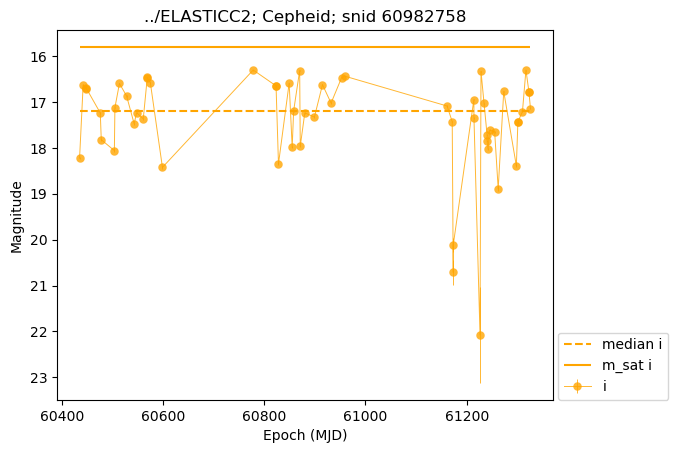

In [3]:
# event, idx = event_fits("../ELASTICC_2", "Cepheid", 60982758 , select = "snid", fit_file = "04", bands = "ugrizY", plot = True, median = True, plot_mags=[(m_sat, "m_sat")])
# event, idx = event_fits("../ELASTICC_2", "Cepheid", 200 , select = "idx", bands = "ugrizY", plot = True, median = True, plot_mags=[(m_sat, "m_sat")])
# event, idx = event_fits("../ELASTICC_2", "Cepheid", 200 , select = "idx", fit_file = "04", bands = "ugrizY", plot = True, median = True, plot_mags=[(m_sat, "m_sat")])
# event, idx = event_fits("../ELASTICC_2", "Cepheid", None , select = "random", bands = "ugrizY", plot = True, median = True, plot_mags=[(m_sat, "m_sat")])
# event, idx = event_dat("../ELASTICC2", "Cepheid", None , select = "random", bands = "ugrizY", plot = True, median = True, plot_mags=[(m_sat, "m_sat")])
# event, idx = event_dat("../ELASTICC2", "Cepheid", 10 , select = "idx", bands = "ugrizY", plot = True, median = True, plot_mags=[(m_sat, "m_sat")])
event, idx = event_dat("../ELASTICC2", "Cepheid", 60982758 , select = "snid", bands = "ugrizY", plot = True, median = True, plot_mags=[(m_sat, "m_sat")])


## Filters

In [ ]:
import numpy as np
import os
import pandas as pd
import shutil

bandcolor_lsst = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}
m_sat_lsst = {'u':14.7, 'g': 15.7, 'r': 15.8, 'i': 15.8, 'z': 15.3, 'y': 13.9}
m_5_lsst = {'u':23.78, 'g':24.81, 'r':24.35 , 'i':23.92, 'z': 23.34 , 'y':22.45}

def filter_m_sat(mjd, m, merr, m_sat):
    try:
        new_mjd, new_m, new_merr= np.array([(mjd_, m_, merr_) for mjd_, m_, merr_ in zip(mjd, m, merr) if (m_ >= m_sat) and (m_!= np.inf)]).T
    except ValueError:
        new_mjd, new_m, new_merr = np.array([]), np.array([]), np.array([])
    del_points = len(m)-len(new_m)
    return new_mjd, new_m, new_merr, del_points

def filter_m_5(mjd, m, merr, m_5, N_points = 10, N_sigma = 1):
    n_high_snr = sum([1 for mjd_, m_, merr_ in zip(mjd, m, merr) if m_+N_sigma*merr_<m_5])
    return n_high_snr > N_points
    
def filter_has_peak(mjd, m, merr, N_points = 4, N_sigma = 3):
    median = np.median(m)
    n_high_m = sum([1 for mjd_, m_, merr_ in zip(mjd, m, merr) if m_+N_sigma*merr_<median])
    return n_high_m > N_points

def filter_chi2_dof(m, merr, cte, upper_limit = None):
    chi = ((m-cte)**2)/(merr**2)
    if upper_limit == None:
        return np.sum(chi)/len(m)
    else:
        return np.sum(chi)/len(m) > upper_limit

def filter_has_variability(mjd, m, merr, N_points = 4, N_sigma = 3):
    median = np.median(m)
    n_distant_m = sum([1 for mjd_, m_, merr_ in zip(mjd, m, merr) if abs(m_-median)>N_sigma*merr_])
    return n_distant_m > N_points


def apply_filters(mjd, mag, mag_err, m_5 = None, m_sat = None,  upper_limit=None, filters = "all"):
    header = ""
    result = []
    if filters == "all":
        filters = ["m_sat", "m_5", "has_peak", "high_chi2", "has_variability"]
    if "m_sat" in filters:
        mjd, mag, mag_err, del_points = filter_m_sat(mjd, mag, mag_err, m_sat)
        header+="del_points\t"
        result+=[del_points]
    if "m_5" in filters:
        valid = filter_m_5(mjd, mag, mag_err, m_5, N_points = 10, N_sigma = 1)
        header+="{}\t".format("valid") 
        result+=[valid]
    if "high_chi2" in filters:
        high_chi2 = filter_chi2_dof(mag, mag_err, np.median(mag), upper_limit = upper_limit)
        header+="{}\t".format("high_chi2") 
        result+=[high_chi2]
    if "has_peak" in filters:
        has_peak = filter_has_peak(mjd, mag, mag_err, N_points = 4, N_sigma = 3)
        header+="{}\t".format("has_peak") 
        result+=[has_peak]
    if "has_variability" in filters:
        has_variability = filter_has_variability(mjd, mag, mag_err, N_points = 4, N_sigma = 3)
        header+="{}\t".format("has_variability")
        result+=[has_variability]
    return mjd, mag, mag_err, list(result), header[:-1]

def lc_to_arrays(lc_dict):
    mjd = lc_dict["mjd"]
    mag = lc_dict["mag"]
    mag_err = lc_dict["mag_err"]
    return mjd, mag, mag_err

def lc_to_dict(band, mjd, mag, mag_err, event = {}):
    lc_dict = {}
    lc_dict["mjd"] = mjd
    lc_dict["mag"] = mag
    lc_dict["mag_err"] = mag_err
    event[band] = lc_dict
    return event

def dataset_apply_filter(dataset_folder, save_path=False):
    '''folder = folder path with the light curves'''
    lc_paths = [lc for lc in os.listdir(dataset_folder) if lc.endswith(".dat")]
    df = pd.DataFrame()
    head_ok = False
    for lc_path in tqdm(lc_paths, position=0):
        mjd, m, merr = np.loadtxt(os.path.join(dataset_folder,lc_path)).T
        mjd, m, merr, results, header = apply_filters(mjd, m, merr, m_5=m_5[band], m_sat=m_sat[band], upper_limit=2, filters="all")
        if not head_ok:
            df_columns = ["lc_path"] + header.split("\t")
            head_ok = True
        results = [lc_path] + results
        row_data = dict(zip(df_columns, results))
        df = pd.concat([df, pd.DataFrame([row_data])], ignore_index=True)
    if save_path!=False:
        df.to_csv(save_path, sep='\t', index=False)
    return df


def dataset_with_cuts(dataset, groups_filters, m_sat, read = True):
#     dataset = "DataSets/ELASTICC2_i"
#     band = "i"
    for class_name in [i for i in os.listdir(dataset) if not "." in i]:
        print(class_name)
        if read:
            df_filt = pd.read_csv(Path(dataset,f"cuts_results_{class_name}.txt"), sep= "\t")
        else:
            df_filt = dataset_apply_filter(Path(dataset, class_name), Path(dataset, f"cuts_results_{class_name}.txt"))
        for group in tqdm(groups_filters, desc = class_name):
            print(group)
            group_dataset_path = dataset[:-1]+group+dataset[-2:]
            os.makedirs(Path(group_dataset_path,class_name), exist_ok=True)
            for filt in groups_filters[group]:
                df_filt = df_filt[df_filt[filt] == True]
            for path in df_filt.lc_path:
                lc_del_points = df_filt[df_filt.lc_path==path].del_points.values[0]
                if lc_del_points>0:
                    mjd, mag, mag_err = np.loadtxt(Path(dataset, class_name, path)).T
                    mjd, mag, mag_err, del_points = filter_m_sat(mjd, mag, mag_err, m_sat)
                    write_lc_file(mjd, mag, mag_err, Path(group_dataset_path,class_name, path))
                else:
                    shutil.copy(Path(dataset,class_name,path), Path(group_dataset_path, class_name, path.split("/")[-1]))

Plotting an event before and after apply cuts:

<timed exec>:24: RuntimeWarning: divide by zero encountered in log10


['del_points', 'valid', 'high_chi2', 'has_peak', 'has_variability']
[1, True, True, False, False]


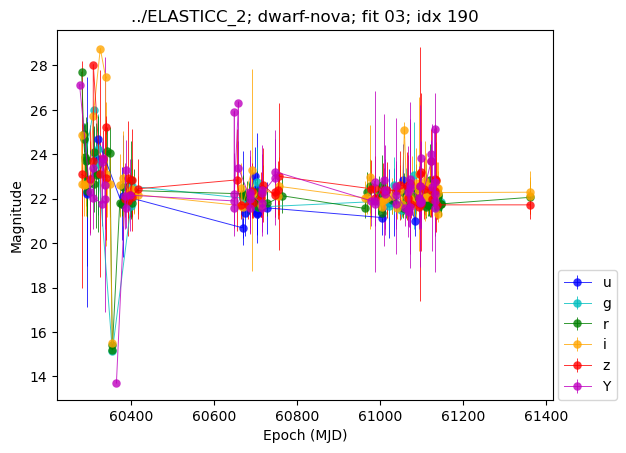

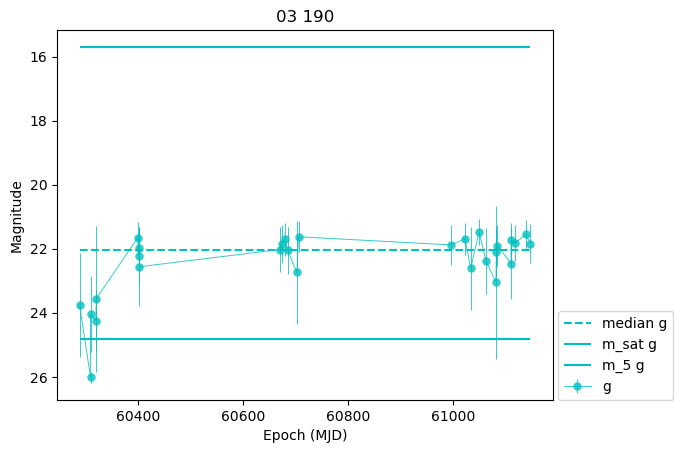

In [5]:
event, fit_file, idx = event_fits("../ELASTICC_2", "dwarf-nova", idx= 190, fit_file = "03" , select = "idx", bands = "ugrizY", plot=True)
band = "g"
mjd, mag, mag_err, result, header = apply_filters(*lc_to_arrays(event[band]), m_5[band], m_sat[band],  upper_limit=2, filters = "all")
plt.figure()
plot_event(lc_to_dict(band, mjd, mag, mag_err), bands=band, median=True, plot_mags=[(m_sat, "m_sat"), (m_5, "m_5")], title =f"{fit_file} {idx}")
print(header.split("\t"))
print(result)

Applying cuts to an entire dataset with .dat format:

In [6]:
dataset_apply_filter("../ELASTICC2_i/Cepheid", save_path="../ELASTICC2_i/Cepheid")

  2%|█▏                                                                            | 305/19672 [00:03<03:37, 89.15it/s]C:\Users\nowok\AppData\Local\Temp\ipykernel_12520\2840049629.py:28: RuntimeWarning: divide by zero encountered in divide
  chi = ((m-cte)**2)/(merr**2)
100%|████████████████████████████████████████████████████████████████████████████| 19672/19672 [04:11<00:00, 78.17it/s]


,lc_path,del_points,valid,high_chi2,has_peak,has_variability
0,lc_10005372_i.dat,0,False,True,False,True
1,lc_10006766_i.dat,0,True,True,True,True
2,lc_10008927_i.dat,0,True,True,True,True
3,lc_10009713_i.dat,0,True,True,True,True
4,lc_10018409_i.dat,0,True,True,True,True
...,...,...,...,...,...,...
19667,lc_997019_i.dat,0,True,True,True,True
19668,lc_9971236_i.dat,0,True,True,False,True
19669,lc_9981582_i.dat,0,True,True,True,True
19670,lc_9984714_i.dat,0,True,True,True,True


Create dataset folders with different combination of cuts:

In [45]:
dataset = "../ELASTICC2_i"
band = "i"
groups_filters = {"Valid":  ["valid"], "Valid_Chi":["valid", "high_chi2"],
                  "Valid_Chi_Peak": ["valid", "has_peak", "high_chi2"],
                  "Valid_Peak":["valid", "has_peak"], "Valid_Chi_Variab": ["valid", "high_chi2", "has_variability"],
                  "Valid_Chi_Peak_Variab": ["valid", "high_chi2", "has_peak", "has_variability"],
                  "Valid_Peak_Variab":["valid", "has_peak", "has_variability"],
                  "Chi":["high_chi2"],
                  "Chi_Peak": ["has_peak", "high_chi2"],
                  "Peak":["has_peak"], "Chi_Variab": ["high_chi2", "has_variability"],
                  "Chi_Peak_Variab": ["high_chi2", "has_peak", "has_variability"],
                  "Peak_Variab":["has_peak", "has_variability"]}
# groups_filters = {"Valid":  ["valid"], "Valid_Chi":["valid", "high_chi2"]}
dataset_with_cuts(dataset, groups_filters, m_sat[band])

Cepheid
Valid
lc_10257778_i.dat with 13 points deleted.
lc_10639107_i.dat with 1 points deleted.
lc_10818485_i.dat with 15 points deleted.
lc_11097883_i.dat with 8 points deleted.
lc_11290549_i.dat with 6 points deleted.
lc_11386493_i.dat with 6 points deleted.
lc_1171299_i.dat with 11 points deleted.
lc_11783853_i.dat with 6 points deleted.
lc_11837865_i.dat with 3 points deleted.
lc_11845718_i.dat with 2 points deleted.
lc_12154330_i.dat with 7 points deleted.
lc_12787925_i.dat with 7 points deleted.
lc_12795588_i.dat with 12 points deleted.
lc_12950950_i.dat with 9 points deleted.
lc_13055632_i.dat with 12 points deleted.
lc_1330991_i.dat with 15 points deleted.
lc_13441021_i.dat with 12 points deleted.
lc_13498559_i.dat with 1 points deleted.
lc_13550866_i.dat with 9 points deleted.
lc_13584185_i.dat with 2 points deleted.
lc_13743217_i.dat with 10 points deleted.
lc_14021309_i.dat with 1 points deleted.
lc_14184249_i.dat with 41 points deleted.
lc_14184377_i.dat with 4 points dele

lc_47876677_i.dat with 21 points deleted.
lc_47959466_i.dat with 3 points deleted.
lc_48050249_i.dat with 2 points deleted.
lc_48081000_i.dat with 3 points deleted.
lc_48246980_i.dat with 2 points deleted.
lc_48517378_i.dat with 25 points deleted.
lc_48518523_i.dat with 12 points deleted.
lc_4856217_i.dat with 10 points deleted.
lc_49122196_i.dat with 1 points deleted.
lc_49201611_i.dat with 5 points deleted.
lc_49629748_i.dat with 4 points deleted.
lc_50043201_i.dat with 1 points deleted.
lc_50257993_i.dat with 5 points deleted.
lc_50260035_i.dat with 7 points deleted.
lc_50554068_i.dat with 8 points deleted.
lc_50723632_i.dat with 4 points deleted.
lc_50738545_i.dat with 13 points deleted.
lc_50971522_i.dat with 4 points deleted.
lc_51025125_i.dat with 9 points deleted.
lc_512095_i.dat with 19 points deleted.
lc_5200232_i.dat with 10 points deleted.
lc_52365731_i.dat with 7 points deleted.
lc_52496442_i.dat with 21 points deleted.
lc_52499255_i.dat with 11 points deleted.
lc_52665703

lc_19952925_i.dat with 2 points deleted.
lc_20152862_i.dat with 6 points deleted.
lc_20260732_i.dat with 16 points deleted.
lc_20615804_i.dat with 9 points deleted.
lc_20706410_i.dat with 1 points deleted.
lc_21221714_i.dat with 7 points deleted.
lc_21291077_i.dat with 4 points deleted.
lc_21511557_i.dat with 3 points deleted.
lc_21533499_i.dat with 7 points deleted.
lc_21622360_i.dat with 3 points deleted.
lc_21734005_i.dat with 3 points deleted.
lc_22299325_i.dat with 5 points deleted.
lc_22730239_i.dat with 5 points deleted.
lc_22749170_i.dat with 19 points deleted.
lc_23181791_i.dat with 6 points deleted.
lc_23566744_i.dat with 15 points deleted.
lc_24237370_i.dat with 2 points deleted.
lc_24240894_i.dat with 12 points deleted.
lc_2510732_i.dat with 2 points deleted.
lc_25289606_i.dat with 6 points deleted.
lc_25363632_i.dat with 3 points deleted.
lc_25488748_i.dat with 62 points deleted.
lc_25498154_i.dat with 14 points deleted.
lc_26188033_i.dat with 5 points deleted.
lc_26203510

lc_60282202_i.dat with 6 points deleted.
lc_60471407_i.dat with 6 points deleted.
lc_60574420_i.dat with 5 points deleted.
lc_60631090_i.dat with 5 points deleted.
lc_60748617_i.dat with 4 points deleted.
lc_60930500_i.dat with 6 points deleted.
lc_61193558_i.dat with 3 points deleted.
lc_61205292_i.dat with 21 points deleted.
lc_61258779_i.dat with 4 points deleted.
lc_61469867_i.dat with 3 points deleted.
lc_61581916_i.dat with 6 points deleted.
lc_61878217_i.dat with 12 points deleted.
lc_62005530_i.dat with 4 points deleted.
lc_6236263_i.dat with 6 points deleted.
lc_62869974_i.dat with 3 points deleted.
lc_62980385_i.dat with 3 points deleted.
lc_63016607_i.dat with 36 points deleted.
lc_63057634_i.dat with 15 points deleted.
lc_63275301_i.dat with 4 points deleted.
lc_63821547_i.dat with 4 points deleted.
lc_63975393_i.dat with 2 points deleted.
lc_65060053_i.dat with 7 points deleted.
lc_65140407_i.dat with 4 points deleted.
lc_65186531_i.dat with 5 points deleted.
lc_65348002_i

lc_34038063_i.dat with 5 points deleted.
lc_35092729_i.dat with 28 points deleted.
lc_35515000_i.dat with 12 points deleted.
lc_35536126_i.dat with 3 points deleted.
lc_35683509_i.dat with 4 points deleted.
lc_35702239_i.dat with 11 points deleted.
lc_35929589_i.dat with 1 points deleted.
lc_36062355_i.dat with 8 points deleted.
lc_36188616_i.dat with 3 points deleted.
lc_36193468_i.dat with 11 points deleted.
lc_36422644_i.dat with 2 points deleted.
lc_36544495_i.dat with 17 points deleted.
lc_36756375_i.dat with 7 points deleted.
lc_36897607_i.dat with 11 points deleted.
lc_36906453_i.dat with 9 points deleted.
lc_37269505_i.dat with 1 points deleted.
lc_37431422_i.dat with 5 points deleted.
lc_37485471_i.dat with 11 points deleted.
lc_37490702_i.dat with 41 points deleted.
lc_37594493_i.dat with 1 points deleted.
lc_37631905_i.dat with 7 points deleted.
lc_37828020_i.dat with 2 points deleted.
lc_38274628_i.dat with 8 points deleted.
lc_38472385_i.dat with 1 points deleted.
lc_38714

lc_73557689_i.dat with 3 points deleted.
lc_73754443_i.dat with 5 points deleted.
lc_7494105_i.dat with 12 points deleted.
lc_7810337_i.dat with 6 points deleted.
lc_7982034_i.dat with 5 points deleted.
lc_8420009_i.dat with 2 points deleted.
lc_8714271_i.dat with 1 points deleted.
lc_8844127_i.dat with 3 points deleted.
lc_9026058_i.dat with 1 points deleted.
lc_9565987_i.dat with 12 points deleted.
lc_9643625_i.dat with 6 points deleted.
lc_9802523_i.dat with 4 points deleted.
Valid_Peak
lc_10257778_i.dat with 13 points deleted.
lc_10639107_i.dat with 1 points deleted.
lc_10818485_i.dat with 15 points deleted.
lc_11097883_i.dat with 8 points deleted.
lc_11290549_i.dat with 6 points deleted.
lc_11386493_i.dat with 6 points deleted.
lc_1171299_i.dat with 11 points deleted.
lc_11783853_i.dat with 6 points deleted.
lc_11837865_i.dat with 3 points deleted.
lc_11845718_i.dat with 2 points deleted.
lc_12154330_i.dat with 7 points deleted.
lc_12787925_i.dat with 7 points deleted.
lc_12795588

lc_46054510_i.dat with 1 points deleted.
lc_46226124_i.dat with 3 points deleted.
lc_46398199_i.dat with 2 points deleted.
lc_46686812_i.dat with 14 points deleted.
lc_46993504_i.dat with 4 points deleted.
lc_47170140_i.dat with 10 points deleted.
lc_47291804_i.dat with 10 points deleted.
lc_47320456_i.dat with 43 points deleted.
lc_47426368_i.dat with 2 points deleted.
lc_47600653_i.dat with 10 points deleted.
lc_47686534_i.dat with 2 points deleted.
lc_47876677_i.dat with 21 points deleted.
lc_47959466_i.dat with 3 points deleted.
lc_48050249_i.dat with 2 points deleted.
lc_48081000_i.dat with 3 points deleted.
lc_48246980_i.dat with 2 points deleted.
lc_48517378_i.dat with 25 points deleted.
lc_48518523_i.dat with 12 points deleted.
lc_4856217_i.dat with 10 points deleted.
lc_49122196_i.dat with 1 points deleted.
lc_49201611_i.dat with 5 points deleted.
lc_49629748_i.dat with 4 points deleted.
lc_50043201_i.dat with 1 points deleted.
lc_50257993_i.dat with 5 points deleted.
lc_50260

lc_19021790_i.dat with 1 points deleted.
lc_19079424_i.dat with 38 points deleted.
lc_19268853_i.dat with 2 points deleted.
lc_19296226_i.dat with 14 points deleted.
lc_19308691_i.dat with 2 points deleted.
lc_19471838_i.dat with 1 points deleted.
lc_19607002_i.dat with 12 points deleted.
lc_19633594_i.dat with 24 points deleted.
lc_19652557_i.dat with 6 points deleted.
lc_1985094_i.dat with 15 points deleted.
lc_19952925_i.dat with 2 points deleted.
lc_20152862_i.dat with 6 points deleted.
lc_20260732_i.dat with 16 points deleted.
lc_20615804_i.dat with 9 points deleted.
lc_20706410_i.dat with 1 points deleted.
lc_21221714_i.dat with 7 points deleted.
lc_21291077_i.dat with 4 points deleted.
lc_21511557_i.dat with 3 points deleted.
lc_21533499_i.dat with 7 points deleted.
lc_21622360_i.dat with 3 points deleted.
lc_21734005_i.dat with 3 points deleted.
lc_22299325_i.dat with 5 points deleted.
lc_22730239_i.dat with 5 points deleted.
lc_22749170_i.dat with 19 points deleted.
lc_2318179

lc_58348723_i.dat with 4 points deleted.
lc_58498697_i.dat with 3 points deleted.
lc_58602403_i.dat with 2 points deleted.
lc_58643435_i.dat with 5 points deleted.
lc_58736043_i.dat with 23 points deleted.
lc_59125922_i.dat with 3 points deleted.
lc_59350650_i.dat with 9 points deleted.
lc_59757699_i.dat with 5 points deleted.
lc_60282202_i.dat with 6 points deleted.
lc_60471407_i.dat with 6 points deleted.
lc_60574420_i.dat with 5 points deleted.
lc_60631090_i.dat with 5 points deleted.
lc_60748617_i.dat with 4 points deleted.
lc_60930500_i.dat with 6 points deleted.
lc_61193558_i.dat with 3 points deleted.
lc_61205292_i.dat with 21 points deleted.
lc_61258779_i.dat with 4 points deleted.
lc_61469867_i.dat with 3 points deleted.
lc_61581916_i.dat with 6 points deleted.
lc_61878217_i.dat with 12 points deleted.
lc_62005530_i.dat with 4 points deleted.
lc_6236263_i.dat with 6 points deleted.
lc_62869974_i.dat with 3 points deleted.
lc_62980385_i.dat with 3 points deleted.
lc_63016607_i.

lc_3302171_i.dat with 1 points deleted.
lc_33094069_i.dat with 10 points deleted.
lc_33640622_i.dat with 2 points deleted.
lc_33701831_i.dat with 3 points deleted.
lc_33821714_i.dat with 22 points deleted.
lc_3402115_i.dat with 5 points deleted.
lc_34038063_i.dat with 5 points deleted.
lc_35092729_i.dat with 28 points deleted.
lc_35515000_i.dat with 12 points deleted.
lc_35536126_i.dat with 3 points deleted.
lc_35683509_i.dat with 4 points deleted.
lc_35702239_i.dat with 11 points deleted.
lc_35929589_i.dat with 1 points deleted.
lc_36062355_i.dat with 8 points deleted.
lc_36188616_i.dat with 3 points deleted.
lc_36193468_i.dat with 11 points deleted.
lc_36422644_i.dat with 2 points deleted.
lc_36544495_i.dat with 17 points deleted.
lc_36756375_i.dat with 7 points deleted.
lc_36897607_i.dat with 11 points deleted.
lc_36906453_i.dat with 9 points deleted.
lc_37269505_i.dat with 1 points deleted.
lc_37431422_i.dat with 5 points deleted.
lc_37485471_i.dat with 11 points deleted.
lc_374907

lc_72089363_i.dat with 14 points deleted.
lc_72802891_i.dat with 24 points deleted.
lc_72931482_i.dat with 7 points deleted.
lc_73144592_i.dat with 4 points deleted.
lc_73401227_i.dat with 7 points deleted.
lc_73557689_i.dat with 3 points deleted.
lc_73754443_i.dat with 5 points deleted.
lc_7494105_i.dat with 12 points deleted.
lc_7810337_i.dat with 6 points deleted.
lc_7982034_i.dat with 5 points deleted.
lc_8420009_i.dat with 2 points deleted.
lc_8714271_i.dat with 1 points deleted.
lc_8844127_i.dat with 3 points deleted.
lc_9026058_i.dat with 1 points deleted.
lc_9565987_i.dat with 12 points deleted.
lc_9643625_i.dat with 6 points deleted.
lc_9802523_i.dat with 4 points deleted.
Valid_Peak_Variab
lc_10257778_i.dat with 13 points deleted.
lc_10639107_i.dat with 1 points deleted.
lc_10818485_i.dat with 15 points deleted.
lc_11097883_i.dat with 8 points deleted.
lc_11290549_i.dat with 6 points deleted.
lc_11386493_i.dat with 6 points deleted.
lc_1171299_i.dat with 11 points deleted.
lc

lc_44904348_i.dat with 7 points deleted.
lc_44996_i.dat with 3 points deleted.
lc_45225466_i.dat with 9 points deleted.
lc_453612_i.dat with 2 points deleted.
lc_45761328_i.dat with 10 points deleted.
lc_46054510_i.dat with 1 points deleted.
lc_46226124_i.dat with 3 points deleted.
lc_46398199_i.dat with 2 points deleted.
lc_46686812_i.dat with 14 points deleted.
lc_46993504_i.dat with 4 points deleted.
lc_47170140_i.dat with 10 points deleted.
lc_47291804_i.dat with 10 points deleted.
lc_47320456_i.dat with 43 points deleted.
lc_47426368_i.dat with 2 points deleted.
lc_47600653_i.dat with 10 points deleted.
lc_47686534_i.dat with 2 points deleted.
lc_47876677_i.dat with 21 points deleted.
lc_47959466_i.dat with 3 points deleted.
lc_48050249_i.dat with 2 points deleted.
lc_48081000_i.dat with 3 points deleted.
lc_48246980_i.dat with 2 points deleted.
lc_48517378_i.dat with 25 points deleted.
lc_48518523_i.dat with 12 points deleted.
lc_4856217_i.dat with 10 points deleted.
lc_49122196_

lc_18027972_i.dat with 11 points deleted.
lc_18540247_i.dat with 6 points deleted.
lc_18786352_i.dat with 3 points deleted.
lc_18830811_i.dat with 5 points deleted.
lc_18893458_i.dat with 8 points deleted.
lc_18906021_i.dat with 7 points deleted.
lc_19021790_i.dat with 1 points deleted.
lc_19079424_i.dat with 38 points deleted.
lc_19268853_i.dat with 2 points deleted.
lc_19296226_i.dat with 14 points deleted.
lc_19308691_i.dat with 2 points deleted.
lc_19471838_i.dat with 1 points deleted.
lc_19607002_i.dat with 12 points deleted.
lc_19633594_i.dat with 24 points deleted.
lc_19652557_i.dat with 6 points deleted.
lc_1985094_i.dat with 15 points deleted.
lc_19952925_i.dat with 2 points deleted.
lc_20152862_i.dat with 6 points deleted.
lc_20260732_i.dat with 16 points deleted.
lc_20615804_i.dat with 9 points deleted.
lc_20706410_i.dat with 1 points deleted.
lc_21221714_i.dat with 7 points deleted.
lc_21291077_i.dat with 4 points deleted.
lc_21511557_i.dat with 3 points deleted.
lc_2153349

lc_57707078_i.dat with 6 points deleted.
lc_57729095_i.dat with 17 points deleted.
lc_58036918_i.dat with 3 points deleted.
lc_58107178_i.dat with 7 points deleted.
lc_58247185_i.dat with 3 points deleted.
lc_58348723_i.dat with 4 points deleted.
lc_58498697_i.dat with 3 points deleted.
lc_58602403_i.dat with 2 points deleted.
lc_58643435_i.dat with 5 points deleted.
lc_58736043_i.dat with 23 points deleted.
lc_59125922_i.dat with 3 points deleted.
lc_59350650_i.dat with 9 points deleted.
lc_59757699_i.dat with 5 points deleted.
lc_60282202_i.dat with 6 points deleted.
lc_60471407_i.dat with 6 points deleted.
lc_60574420_i.dat with 5 points deleted.
lc_60631090_i.dat with 5 points deleted.
lc_60748617_i.dat with 4 points deleted.
lc_60930500_i.dat with 6 points deleted.
lc_61193558_i.dat with 3 points deleted.
lc_61205292_i.dat with 21 points deleted.
lc_61258779_i.dat with 4 points deleted.
lc_61469867_i.dat with 3 points deleted.
lc_61581916_i.dat with 6 points deleted.
lc_61878217_i

lc_31531150_i.dat with 4 points deleted.
lc_31644873_i.dat with 7 points deleted.
lc_31889495_i.dat with 8 points deleted.
lc_32213997_i.dat with 3 points deleted.
lc_32650358_i.dat with 7 points deleted.
lc_32692450_i.dat with 4 points deleted.
lc_32782133_i.dat with 15 points deleted.
lc_3302171_i.dat with 1 points deleted.
lc_33094069_i.dat with 10 points deleted.
lc_33640622_i.dat with 2 points deleted.
lc_33701831_i.dat with 3 points deleted.
lc_33821714_i.dat with 22 points deleted.
lc_3402115_i.dat with 5 points deleted.
lc_34038063_i.dat with 5 points deleted.
lc_35092729_i.dat with 28 points deleted.
lc_35515000_i.dat with 12 points deleted.
lc_35536126_i.dat with 3 points deleted.
lc_35683509_i.dat with 4 points deleted.
lc_35702239_i.dat with 11 points deleted.
lc_35929589_i.dat with 1 points deleted.
lc_36062355_i.dat with 8 points deleted.
lc_36188616_i.dat with 3 points deleted.
lc_36193468_i.dat with 11 points deleted.
lc_36422644_i.dat with 2 points deleted.
lc_36544495

lc_71307446_i.dat with 4 points deleted.
lc_71338160_i.dat with 2 points deleted.
lc_71617402_i.dat with 4 points deleted.
lc_71644527_i.dat with 1 points deleted.
lc_71696388_i.dat with 3 points deleted.
lc_71846357_i.dat with 17 points deleted.
lc_71918177_i.dat with 10 points deleted.
lc_72051059_i.dat with 5 points deleted.
lc_72074366_i.dat with 1 points deleted.
lc_72089363_i.dat with 14 points deleted.
lc_72802891_i.dat with 24 points deleted.
lc_72931482_i.dat with 7 points deleted.
lc_73144592_i.dat with 4 points deleted.
lc_73401227_i.dat with 7 points deleted.
lc_73557689_i.dat with 3 points deleted.
lc_73754443_i.dat with 5 points deleted.
lc_7494105_i.dat with 12 points deleted.
lc_7810337_i.dat with 6 points deleted.
lc_7982034_i.dat with 5 points deleted.
lc_8420009_i.dat with 2 points deleted.
lc_8714271_i.dat with 1 points deleted.
lc_8844127_i.dat with 3 points deleted.
lc_9026058_i.dat with 1 points deleted.
lc_9565987_i.dat with 12 points deleted.
lc_9643625_i.dat w

lc_42524592_i.dat with 4 points deleted.
lc_42687521_i.dat with 4 points deleted.
lc_42730692_i.dat with 9 points deleted.
lc_42867369_i.dat with 10 points deleted.
lc_43067925_i.dat with 4 points deleted.
lc_43139525_i.dat with 1 points deleted.
lc_4406507_i.dat with 4 points deleted.
lc_44102547_i.dat with 2 points deleted.
lc_44219027_i.dat with 5 points deleted.
lc_44904348_i.dat with 7 points deleted.
lc_44996_i.dat with 3 points deleted.
lc_45225466_i.dat with 9 points deleted.
lc_453612_i.dat with 2 points deleted.
lc_45761328_i.dat with 10 points deleted.
lc_46054510_i.dat with 1 points deleted.
lc_46226124_i.dat with 3 points deleted.
lc_46398199_i.dat with 2 points deleted.
lc_46686812_i.dat with 14 points deleted.
lc_46993504_i.dat with 4 points deleted.
lc_47170140_i.dat with 10 points deleted.
lc_47291804_i.dat with 10 points deleted.
lc_47320456_i.dat with 43 points deleted.
lc_47426368_i.dat with 2 points deleted.
lc_47600653_i.dat with 10 points deleted.
lc_47686534_i.d

lc_15926936_i.dat with 2 points deleted.
lc_16032588_i.dat with 2 points deleted.
lc_16497448_i.dat with 5 points deleted.
lc_16798686_i.dat with 9 points deleted.
lc_16857881_i.dat with 3 points deleted.
lc_16942922_i.dat with 14 points deleted.
lc_17206902_i.dat with 25 points deleted.
lc_17388742_i.dat with 3 points deleted.
lc_17394256_i.dat with 10 points deleted.
lc_18027972_i.dat with 11 points deleted.
lc_18540247_i.dat with 6 points deleted.
lc_18786352_i.dat with 3 points deleted.
lc_18830811_i.dat with 5 points deleted.
lc_18893458_i.dat with 8 points deleted.
lc_18906021_i.dat with 7 points deleted.
lc_19021790_i.dat with 1 points deleted.
lc_19079424_i.dat with 38 points deleted.
lc_19268853_i.dat with 2 points deleted.
lc_19296226_i.dat with 14 points deleted.
lc_19308691_i.dat with 2 points deleted.
lc_19471838_i.dat with 1 points deleted.
lc_19607002_i.dat with 12 points deleted.
lc_19633594_i.dat with 24 points deleted.
lc_19652557_i.dat with 6 points deleted.
lc_19850

lc_56166845_i.dat with 14 points deleted.
lc_56186003_i.dat with 20 points deleted.
lc_56268605_i.dat with 1 points deleted.
lc_56802096_i.dat with 6 points deleted.
lc_56852093_i.dat with 20 points deleted.
lc_57008791_i.dat with 7 points deleted.
lc_57376585_i.dat with 4 points deleted.
lc_57533332_i.dat with 14 points deleted.
lc_57707078_i.dat with 6 points deleted.
lc_57729095_i.dat with 17 points deleted.
lc_58036918_i.dat with 3 points deleted.
lc_58107178_i.dat with 7 points deleted.
lc_58247185_i.dat with 3 points deleted.
lc_58348723_i.dat with 4 points deleted.
lc_58498697_i.dat with 3 points deleted.
lc_58602403_i.dat with 2 points deleted.
lc_58643435_i.dat with 5 points deleted.
lc_58736043_i.dat with 23 points deleted.
lc_59125922_i.dat with 3 points deleted.
lc_59350650_i.dat with 9 points deleted.
lc_59757699_i.dat with 5 points deleted.
lc_60282202_i.dat with 6 points deleted.
lc_60471407_i.dat with 6 points deleted.
lc_60574420_i.dat with 5 points deleted.
lc_6063109

lc_3010368_i.dat with 12 points deleted.
lc_30382918_i.dat with 6 points deleted.
lc_30931684_i.dat with 7 points deleted.
lc_31018496_i.dat with 6 points deleted.
lc_31060514_i.dat with 21 points deleted.
lc_31096364_i.dat with 7 points deleted.
lc_31271643_i.dat with 20 points deleted.
lc_31531150_i.dat with 4 points deleted.
lc_31644873_i.dat with 7 points deleted.
lc_31889495_i.dat with 8 points deleted.
lc_32213997_i.dat with 3 points deleted.
lc_32650358_i.dat with 7 points deleted.
lc_32692450_i.dat with 4 points deleted.
lc_32782133_i.dat with 15 points deleted.
lc_3302171_i.dat with 1 points deleted.
lc_33094069_i.dat with 10 points deleted.
lc_33640622_i.dat with 2 points deleted.
lc_33701831_i.dat with 3 points deleted.
lc_33821714_i.dat with 22 points deleted.
lc_3402115_i.dat with 5 points deleted.
lc_34038063_i.dat with 5 points deleted.
lc_35092729_i.dat with 28 points deleted.
lc_35515000_i.dat with 12 points deleted.
lc_35536126_i.dat with 3 points deleted.
lc_35683509

lc_69516004_i.dat with 5 points deleted.
lc_7045137_i.dat with 1 points deleted.
lc_70665350_i.dat with 1 points deleted.
lc_70675505_i.dat with 6 points deleted.
lc_70690983_i.dat with 20 points deleted.
lc_70751894_i.dat with 2 points deleted.
lc_71307446_i.dat with 4 points deleted.
lc_71338160_i.dat with 2 points deleted.
lc_71617402_i.dat with 4 points deleted.
lc_71644527_i.dat with 1 points deleted.
lc_71696388_i.dat with 3 points deleted.
lc_71846357_i.dat with 17 points deleted.
lc_71918177_i.dat with 10 points deleted.
lc_72051059_i.dat with 5 points deleted.
lc_72074366_i.dat with 1 points deleted.
lc_72089363_i.dat with 14 points deleted.
lc_72802891_i.dat with 24 points deleted.
lc_72931482_i.dat with 7 points deleted.
lc_73144592_i.dat with 4 points deleted.
lc_73401227_i.dat with 7 points deleted.
lc_73557689_i.dat with 3 points deleted.
lc_73754443_i.dat with 5 points deleted.
lc_7494105_i.dat with 12 points deleted.
lc_7810337_i.dat with 6 points deleted.
lc_7982034_i.

lc_41910267_i.dat with 34 points deleted.
lc_41987594_i.dat with 13 points deleted.
lc_42056405_i.dat with 1 points deleted.
lc_42141077_i.dat with 8 points deleted.
lc_42524592_i.dat with 4 points deleted.
lc_42687521_i.dat with 4 points deleted.
lc_42730692_i.dat with 9 points deleted.
lc_42867369_i.dat with 10 points deleted.
lc_43067925_i.dat with 4 points deleted.
lc_43139525_i.dat with 1 points deleted.
lc_4406507_i.dat with 4 points deleted.
lc_44102547_i.dat with 2 points deleted.
lc_44219027_i.dat with 5 points deleted.
lc_44904348_i.dat with 7 points deleted.
lc_44996_i.dat with 3 points deleted.
lc_45225466_i.dat with 9 points deleted.
lc_453612_i.dat with 2 points deleted.
lc_45761328_i.dat with 10 points deleted.
lc_46054510_i.dat with 1 points deleted.
lc_46226124_i.dat with 3 points deleted.
lc_46398199_i.dat with 2 points deleted.
lc_46686812_i.dat with 14 points deleted.
lc_46993504_i.dat with 4 points deleted.
lc_47170140_i.dat with 10 points deleted.
lc_47291804_i.da

lc_39202785_i.dat with 4 points deleted.
lc_41682363_i.dat with 4 points deleted.
lc_43011393_i.dat with 8 points deleted.
lc_46328061_i.dat with 14 points deleted.
lc_48703561_i.dat with 11 points deleted.
lc_49895912_i.dat with 6 points deleted.
lc_50531161_i.dat with 8 points deleted.
lc_54642911_i.dat with 40 points deleted.
lc_57267746_i.dat with 1 points deleted.
lc_59840088_i.dat with 1 points deleted.
lc_59921234_i.dat with 2 points deleted.
lc_59989989_i.dat with 14 points deleted.
lc_61515187_i.dat with 7 points deleted.
lc_63521729_i.dat with 3 points deleted.
lc_64429981_i.dat with 4 points deleted.
lc_65102830_i.dat with 1 points deleted.
lc_65245732_i.dat with 14 points deleted.
lc_66735938_i.dat with 12 points deleted.
lc_6765421_i.dat with 11 points deleted.
lc_67825627_i.dat with 1 points deleted.
lc_68851349_i.dat with 5 points deleted.
lc_69810652_i.dat with 6 points deleted.
lc_70429721_i.dat with 3 points deleted.
lc_70799117_i.dat with 6 points deleted.
lc_7153903

lc_59921234_i.dat with 2 points deleted.
lc_59989989_i.dat with 14 points deleted.
lc_61515187_i.dat with 7 points deleted.
lc_63521729_i.dat with 3 points deleted.
lc_64429981_i.dat with 4 points deleted.
lc_65102830_i.dat with 1 points deleted.
lc_65245732_i.dat with 14 points deleted.
lc_66735938_i.dat with 12 points deleted.
lc_6765421_i.dat with 11 points deleted.
lc_67825627_i.dat with 1 points deleted.
lc_68851349_i.dat with 5 points deleted.
lc_69810652_i.dat with 6 points deleted.
lc_70429721_i.dat with 3 points deleted.
lc_70799117_i.dat with 6 points deleted.
lc_71539036_i.dat with 6 points deleted.
lc_73239420_i.dat with 3 points deleted.
lc_7518707_i.dat with 2 points deleted.
lc_7728129_i.dat with 5 points deleted.
lc_8160478_i.dat with 4 points deleted.
lc_8879329_i.dat with 34 points deleted.
Valid_Chi_Variab
lc_1082349_i.dat with 11 points deleted.
lc_10965168_i.dat with 8 points deleted.
lc_11789654_i.dat with 4 points deleted.
lc_12253603_i.dat with 8 points deleted.

lc_67825627_i.dat with 1 points deleted.
lc_68851349_i.dat with 5 points deleted.
lc_69810652_i.dat with 6 points deleted.
lc_70429721_i.dat with 3 points deleted.
lc_70799117_i.dat with 6 points deleted.
lc_71539036_i.dat with 6 points deleted.
lc_73239420_i.dat with 3 points deleted.
lc_7518707_i.dat with 2 points deleted.
lc_7728129_i.dat with 5 points deleted.
lc_8160478_i.dat with 4 points deleted.
lc_8879329_i.dat with 34 points deleted.
Chi
lc_1082349_i.dat with 11 points deleted.
lc_10965168_i.dat with 8 points deleted.
lc_11789654_i.dat with 4 points deleted.
lc_12253603_i.dat with 8 points deleted.
lc_1342295_i.dat with 2 points deleted.
lc_14171221_i.dat with 5 points deleted.
lc_15019247_i.dat with 7 points deleted.
lc_15289439_i.dat with 3 points deleted.
lc_15502806_i.dat with 8 points deleted.
lc_15662951_i.dat with 4 points deleted.
lc_17048123_i.dat with 1 points deleted.
lc_18058005_i.dat with 21 points deleted.
lc_18769634_i.dat with 13 points deleted.
lc_19058354_i.

Chi_Variab
lc_1082349_i.dat with 11 points deleted.
lc_10965168_i.dat with 8 points deleted.
lc_11789654_i.dat with 4 points deleted.
lc_12253603_i.dat with 8 points deleted.
lc_1342295_i.dat with 2 points deleted.
lc_14171221_i.dat with 5 points deleted.
lc_15019247_i.dat with 7 points deleted.
lc_15289439_i.dat with 3 points deleted.
lc_15502806_i.dat with 8 points deleted.
lc_15662951_i.dat with 4 points deleted.
lc_17048123_i.dat with 1 points deleted.
lc_18058005_i.dat with 21 points deleted.
lc_18769634_i.dat with 13 points deleted.
lc_19058354_i.dat with 3 points deleted.
lc_20139719_i.dat with 5 points deleted.
lc_20518024_i.dat with 4 points deleted.
lc_21362380_i.dat with 12 points deleted.
lc_21536541_i.dat with 14 points deleted.
lc_21862891_i.dat with 4 points deleted.
lc_25083930_i.dat with 5 points deleted.
lc_27982294_i.dat with 9 points deleted.
lc_28014953_i.dat with 4 points deleted.
lc_30330833_i.dat with 3 points deleted.
lc_31488333_i.dat with 7 points deleted.
lc

lc_11697235_i.dat with 1 points deleted.
lc_12549700_i.dat with 5 points deleted.
lc_12551122_i.dat with 2 points deleted.
lc_12552822_i.dat with 3 points deleted.
lc_12668876_i.dat with 3 points deleted.
lc_12746046_i.dat with 2 points deleted.
lc_13238078_i.dat with 2 points deleted.
lc_13300480_i.dat with 1 points deleted.
lc_13549105_i.dat with 2 points deleted.
lc_13656372_i.dat with 4 points deleted.
lc_13881767_i.dat with 3 points deleted.
lc_14028240_i.dat with 5 points deleted.
lc_14094996_i.dat with 3 points deleted.
lc_14245403_i.dat with 1 points deleted.
lc_14851061_i.dat with 1 points deleted.
lc_15121395_i.dat with 2 points deleted.
lc_15157549_i.dat with 1 points deleted.
lc_15502649_i.dat with 2 points deleted.
lc_15818569_i.dat with 3 points deleted.
lc_15915510_i.dat with 1 points deleted.
lc_16173037_i.dat with 2 points deleted.
lc_16184679_i.dat with 3 points deleted.
lc_1651531_i.dat with 2 points deleted.
lc_17159638_i.dat with 1 points deleted.
lc_17526340_i.dat

lc_52967824_i.dat with 1 points deleted.
lc_53007502_i.dat with 2 points deleted.
lc_53026868_i.dat with 1 points deleted.
lc_53290634_i.dat with 4 points deleted.
lc_53931522_i.dat with 1 points deleted.
lc_54005730_i.dat with 2 points deleted.
lc_54343254_i.dat with 4 points deleted.
lc_54492554_i.dat with 4 points deleted.
lc_54500004_i.dat with 3 points deleted.
lc_54662759_i.dat with 2 points deleted.
lc_54721886_i.dat with 1 points deleted.
lc_55327151_i.dat with 2 points deleted.
lc_55873807_i.dat with 3 points deleted.
lc_55995870_i.dat with 2 points deleted.
lc_5603778_i.dat with 1 points deleted.
lc_56192502_i.dat with 2 points deleted.
lc_56432868_i.dat with 2 points deleted.
lc_56559189_i.dat with 1 points deleted.
lc_56663076_i.dat with 2 points deleted.
lc_56735025_i.dat with 2 points deleted.
lc_57219743_i.dat with 1 points deleted.
lc_57320029_i.dat with 2 points deleted.
lc_57526983_i.dat with 4 points deleted.
lc_57905294_i.dat with 3 points deleted.
lc_57981551_i.dat

lc_32238720_i.dat with 1 points deleted.
lc_32250785_i.dat with 1 points deleted.
lc_32441621_i.dat with 2 points deleted.
lc_32882408_i.dat with 2 points deleted.
lc_33369074_i.dat with 2 points deleted.
lc_33585302_i.dat with 3 points deleted.
lc_33951043_i.dat with 5 points deleted.
lc_3428164_i.dat with 1 points deleted.
lc_34291870_i.dat with 3 points deleted.
lc_34382478_i.dat with 3 points deleted.
lc_34422553_i.dat with 6 points deleted.
lc_34904412_i.dat with 3 points deleted.
lc_35012252_i.dat with 3 points deleted.
lc_35053597_i.dat with 5 points deleted.
lc_35105478_i.dat with 1 points deleted.
lc_35439936_i.dat with 3 points deleted.
lc_35488725_i.dat with 2 points deleted.
lc_35798014_i.dat with 2 points deleted.
lc_36320181_i.dat with 2 points deleted.
lc_36356838_i.dat with 2 points deleted.
lc_36392485_i.dat with 1 points deleted.
lc_36403602_i.dat with 2 points deleted.
lc_36540984_i.dat with 2 points deleted.
lc_36578826_i.dat with 2 points deleted.
lc_36650136_i.dat

lc_63287775_i.dat with 2 points deleted.
lc_71268526_i.dat with 5 points deleted.
lc_7622861_i.dat with 1 points deleted.
lc_7934736_i.dat with 1 points deleted.
Valid_Chi_Variab
lc_20368659_i.dat with 1 points deleted.
lc_26985056_i.dat with 2 points deleted.
lc_4196368_i.dat with 1 points deleted.
lc_44726306_i.dat with 3 points deleted.
lc_60161005_i.dat with 3 points deleted.
lc_63287775_i.dat with 2 points deleted.
lc_71268526_i.dat with 5 points deleted.
lc_7622861_i.dat with 1 points deleted.
lc_7934736_i.dat with 1 points deleted.
Valid_Chi_Peak_Variab
lc_20368659_i.dat with 1 points deleted.
lc_26985056_i.dat with 2 points deleted.
lc_4196368_i.dat with 1 points deleted.
lc_44726306_i.dat with 3 points deleted.
lc_60161005_i.dat with 3 points deleted.
lc_63287775_i.dat with 2 points deleted.
lc_71268526_i.dat with 5 points deleted.
lc_7622861_i.dat with 1 points deleted.
lc_7934736_i.dat with 1 points deleted.
Valid_Peak_Variab
lc_20368659_i.dat with 1 points deleted.
lc_26985

KeyboardInterrupt: 

# ESTA PARTE ESTA MUCHO MEJOR EN LINCC!!
# DataSet 
## Properties

Amount of light curves per category of a data set

Counting light curves per category of ../ELASTICC2_fits: 100%|█████████████████████████| 32/32 [02:12<00:00,  4.14s/it]


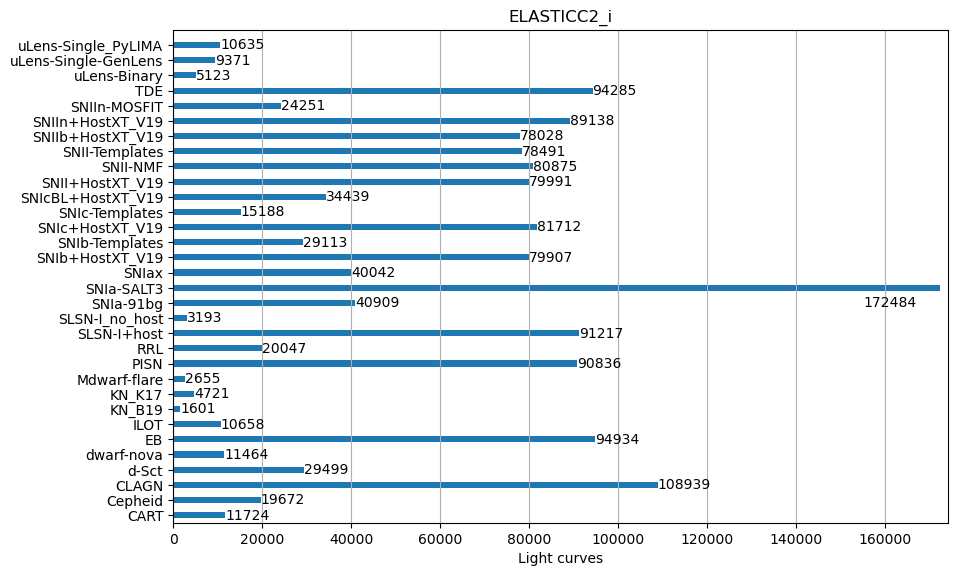

In [48]:
from astropy.io import fits
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt

def count_lc(catalog, data_format = "dat"):
    n_lc={}
    class_names = [i for i in  os.listdir(catalog) if not "." in i]
    if data_format == "fits":
        for folder in tqdm(class_names, desc= f"Counting light curves per category of {catalog}"):
            filenames_HEAD = [file for file in os.listdir(Path(catalog, folder)) if '_HEAD.FITS' in file]
            n = []
            for head in filenames_HEAD:
                with fits.open(Path(catalog,folder,head)) as hdu:
                    n.append(len(hdu[1].data))
            n_lc[folder]=sum(n)
    if data_format == "dat":
        for folder in tqdm(class_names, desc=f"Counting light curves per category of {catalog}"):
            if folder == "proc":
                continue
            lc_class = [lc for lc in os.listdir(Path(catalog, folder)) if 'lc_' in lc]
            n_lc[folder]=len(lc_class)
    return n_lc

def plot_count_lc(n_lc, kind="bar", title = None,  gal = False ):
    labels, values = list(n_lc.keys()), list(n_lc.values())
    labels = [i[len(os.path.commonprefix(labels)):] for i in labels]
    if kind == "bar":
        n = len(labels)
        plt.figure(figsize = (10,n*0.2))
        if gal == True:
            gal = ["Cepheid", "d-Sct", "dwarf-nova","EB", "Mdwarf-flare", "RRL", "uLens-Binary", 
                   "uLens-Single-GenLens", "uLens-Single_PyLIMA"]
            extra_gal = [lab for lab in labels if lab not in gal]
            val_gal = []; val_extra_gal = []
            for val, lab in zip(values, labels):
                if lab in gal:
                    val_gal.append(val)
                else:
                    val_extra_gal.append(val)
            if (len(val_gal) == 0) or (len(val_extra_gal) == 0):
                plt.barh(labels,values, height=0.4)
            else:
                plt.barh(gal, val_gal, height=0.4, label = "Galactic")
                plt.barh(extra_gal, val_extra_gal, height=0.4, label = "Extragalactic")
                plt.legend()

        else:        
            plt.barh(labels,values, height=0.4)
        plt.grid(axis="x")
        plt.xlabel("Light curves")
        for i, (label, value) in enumerate(zip(labels, values)):
            if value == max(values):
                plt.text(value*(4.5/5), labels[i-1], str(value), va='center')
            else:
                plt.text(value, label, str(value), va='center')
        plt.ylim(-0.5, len(labels))
        plt.xlim(0, max(values)*1.01)
    if kind == "pie":
        wedges, label, j = plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
        for i, (wedge, label) in enumerate(zip(wedges, labels)):
            theta = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
            x = 0.9 * np.cos(theta * np.pi / 180)
            y = 0.9 * np.sin(theta * np.pi / 180)
            plt.text(x*0.95, y*0.95, f'{values[i]}', ha='center', va='center')
            plt.plot([x*1.05, 1.15 * x], [y*1.05, 1.15 * y], color='black', linestyle='--', linewidth=0.5)
    #         plt.legend(labels, loc=(1,1)) 
    plt.title(title)
    plt.show()

# n_lc = get_n_lc("ELASTICC2_fits", data_format = "fits")

n_lc = count_lc("../ELASTICC2_fits", data_format = "fits")
plot_count_lc(n_lc, kind = "bar", title = "ELASTICC2_i", gal = False)

Size of each category of a dataset.

Computing size of categories: 100%|██████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.42s/it]


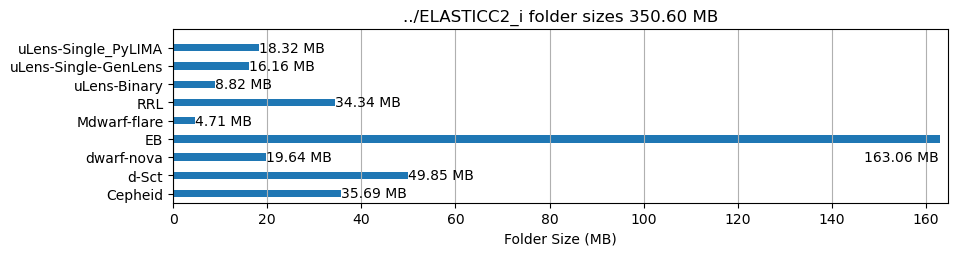

In [49]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

def get_sizes(catalog, data_format = "dat"):
    categories_sizes = {}
    class_names = [folder for folder in os.listdir(catalog) if not "." in folder]
    for folder in tqdm(class_names, desc = "Computing size of categories"):
        folder_path = Path(catalog, folder)
        categories_sizes[folder] = sum(f.stat().st_size for f in folder_path.glob('**/*') if f.is_file()) / (1024 * 1024)
    return categories_sizes

def plot_sizes(categories_sizes, title="Folder Sizes"):
    labels, sizes = list(categories_sizes.keys()), list(categories_sizes.values())
    labels = [i[len(os.path.commonprefix(labels)):] for i in labels]
    n = len(labels)
    plt.figure(figsize=(10, n * 0.25))

    plt.barh(labels, sizes, height=0.4)
    plt.grid(axis="x")
    plt.xlabel("Folder Size (MB)")
    plt.xlim(0, max(sizes)*1.01)
    plt.ylim(-0.5, len(labels))

    for i, (label, size) in enumerate(zip(labels, sizes)):
        if size == max(sizes):
            plt.text(size*(4.5/5), labels[i-1], f'{size:.2f} MB', va='center')
        else:
            plt.text(size, label, f'{size:.2f} MB', va='center')

    plt.title(title + f" {sum(sizes):.2f} MB")
    plt.show()
folder_path = "../ELASTICC2_i"
folder_sizes = get_sizes(folder_path)
plot_sizes(folder_sizes, title=f"{folder_path} folder sizes")


Counting light curves per category of ../ELASTICC2_i: 100%|██████████████████████████████| 9/9 [00:00<00:00, 14.23it/s]


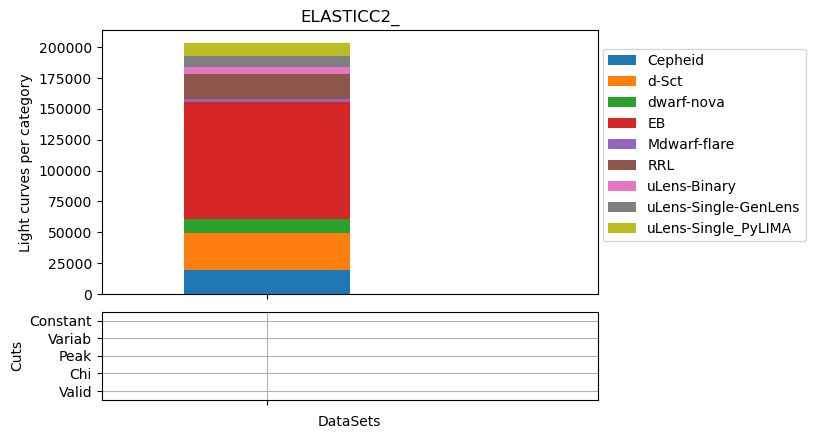

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_balance_subdatasets(catalog, cuts=False):
    data = {}
    for dataset in [i for i in os.listdir("..") if ("ELASTICC2_i" in i) and (not "." in i)]:
        data[dataset] = get_n_lc("../"+dataset, data_format = "dat")
    datasets = list(data.keys())
    datasets_labels = [i[len(os.path.commonprefix(list(data.keys())))+1:] for i in list(data.keys())]
    bar_positions = range(len(datasets))
    bottom_values = [0] * len(datasets)  # Inicializa la variable "bottom_values" en ceros
    categories = []
    for dataset in datasets:
        cat = [i for i in data[dataset].keys() if i!="proc"]
        if len(cat) > len(categories):
            categories = cat
    
    if cuts == True:
        groups_filters = {"Valid":  ["valid"], "Chi":["high_chi2"], "Peak":["has_peak"],"Variab": ["has_variability"], "Constant": ["Constant"]}

        filter_matrix = np.zeros((len(groups_filters), len(datasets)), dtype=bool)
        for i, dataset in enumerate(datasets):
            for j, cut in enumerate(groups_filters):
                if cut in dataset:
                    filter_matrix[j, i] = True

        fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
        plt.subplots_adjust(hspace=0.1)
        ax1.set_title(catalog)
        bar_width = 0.5  
        bar_positions = np.arange(len(datasets))  
        bottom = np.zeros(len(datasets))    
        for i, category in enumerate(categories):
            category_data = []
            for dataset in datasets:
                try:
                    category_data.append(data[dataset][category])
                except:
                    category_data.append(0)
            ax1.bar(bar_positions, category_data, label=category, bottom=bottom, width=bar_width)
            bottom += np.array(category_data)  

        ax1.set_xticks(bar_positions)
        ax1.set_xlim(-0.5,len(bottom))
        ax1.set_xticklabels([])  
        ax2.set_xticks(bar_positions)  
        ax2.set_xticklabels(datasets_labels, rotation=90)
        ax2.set_xlim(-0.5,len(bottom))
        ax2.grid()
        for i in range(len(groups_filters)):
            for j in range(len(datasets)):
                if filter_matrix[i, j]:
                    ax2.scatter(j, i, marker='o', s=50, color='blue', edgecolor='black', linewidth=1)  # Agregar borde negro a los círculos

        ax2.set_yticks(range(len(groups_filters)))
        ax2.set_ylabel("Cuts")
        ax2.set_yticklabels(groups_filters, rotation=0)
        ax2.set_xlabel('DataSets')
        ax2.set_ylim(-0.5,len(groups_filters)-0.5)

        # Añade etiquetas y leyenda al subgráfico superior
        ax1.set_ylabel('Light curves per category')
        ax1.legend(loc=(1.01, 0.2))
    else:
        
        for i, category in enumerate(categories):
            try:
                category_data = [data[dataset][category] for dataset in datasets]
            except:
                pass
            plt.bar(bar_positions, category_data, label=category, bottom=bottom_values)

            # Actualiza "bottom_values" para la próxima categoría
            bottom_values = [bottom_values[j] + category_data[j] for j in range(len(datasets))]
        plt.title(catalog)
        plt.xlabel('Datasets')
        plt.ylabel('Light curves per category')
        plt.xticks(bar_positions, datasets_labels, rotation = 90)
        plt.legend(loc = (1.05,0.2))
    return data

data = plot_balance_subdatasets("ELASTICC2_", cuts = True)

Counting light curves per category of DataSets/ELASTICC2_Chi_i: 100%|████████████████████| 3/3 [00:00<00:00, 18.13it/s]
Counting light curves per category of DataSets/ELASTICC2_Chi_Peak_i: 100%|███████████████| 3/3 [00:00<00:00, 23.48it/s]
Counting light curves per category of DataSets/ELASTICC2_Chi_Peak_Variab_i: 100%|████████| 3/3 [00:02<00:00,  1.48it/s]
Counting light curves per category of DataSets/ELASTICC2_Chi_Variab_i: 100%|█████████████| 3/3 [00:02<00:00,  1.31it/s]
Counting light curves per category of DataSets/ELASTICC2_i: 100%|████████████████████████| 9/9 [00:04<00:00,  2.15it/s]
Counting light curves per category of DataSets/ELASTICC2_Peak_i: 100%|███████████████████| 3/3 [00:02<00:00,  1.16it/s]
Counting light curves per category of DataSets/ELASTICC2_Peak_Variab_i: 100%|████████████| 3/3 [00:02<00:00,  1.30it/s]
Counting light curves per category of DataSets/ELASTICC2_Valid_Chi_i: 100%|██████████████| 4/4 [00:04<00:00,  1.10s/it]
Counting light curves per category of Da

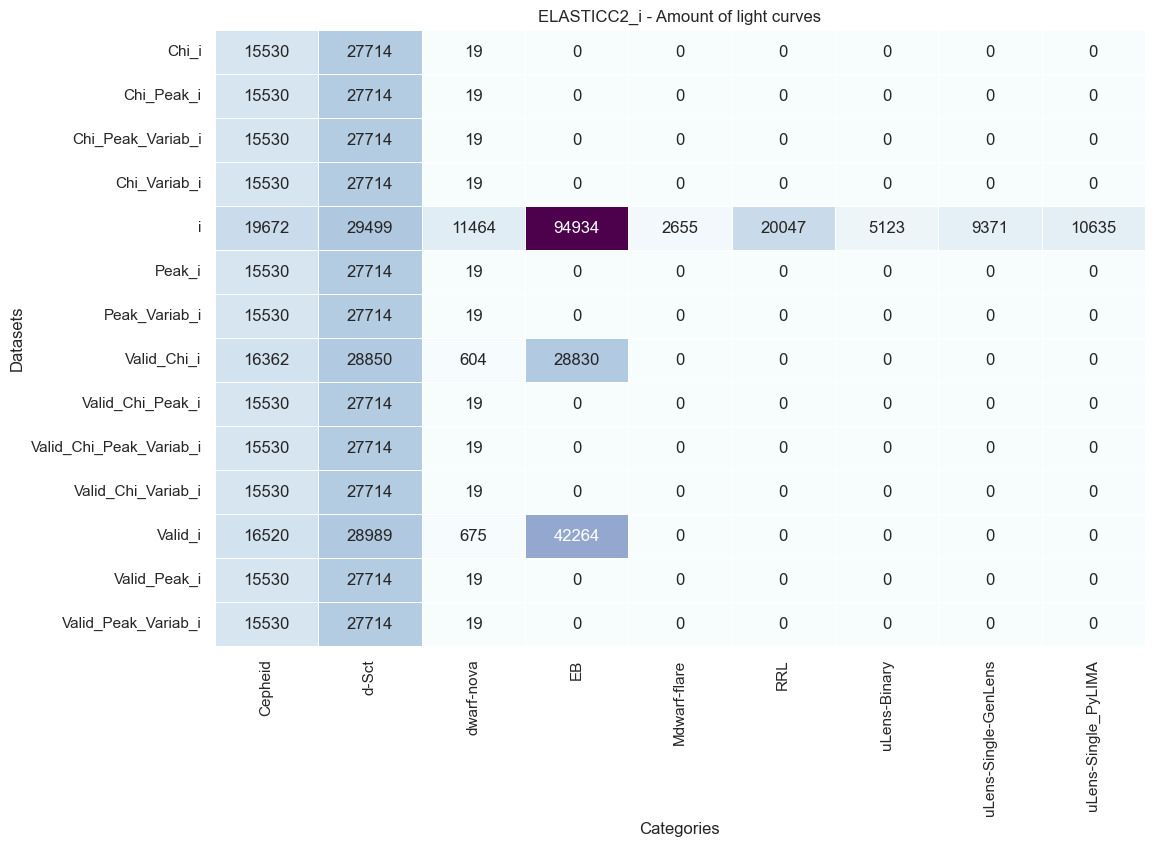

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

def count_lc(catalog, data_format = "dat"):
    n_lc={}
    class_names = [i for i in  os.listdir(catalog) if not "." in i]
    if data_format == "fits":
        for folder in tqdm(class_names, desc= f"Counting light curves per category of {catalog}"):
            filenames_HEAD = [file for file in os.listdir(Path(catalog, folder)) if '_HEAD.FITS' in file]
            n = []
            for head in filenames_HEAD:
                with fits.open(Path(catalog,folder,head)) as hdu:
                    n.append(len(hdu[1].data))
            n_lc[folder]=sum(n)
    if data_format == "dat":
        for folder in tqdm(class_names, desc=f"Counting light curves per category of {catalog}"):
            lc_class = [lc for lc in os.listdir(Path(catalog, folder)) if 'lc_' in lc]
            n_lc[folder]=len(lc_class)
    return n_lc

def count_subdatasets_lc(catalog, data_format = "dat", also_contains = None):
    data = {}
    if also_contains != None:
        datasets = [i for i in os.listdir("DataSets") if (catalog in i) and (also_contains in i) and (not "." in i)]
    else:
        datasets = [i for i in os.listdir("DataSets") if (catalog in i) and (not "." in i)]
    for dataset in datasets:
        data[dataset] = count_lc("DataSets/"+dataset, data_format = data_format)
    return data

def plot_balance_subdatasets(data, title="", kind="bar", cuts=False):
    '''kind: "bar" or "heatmap"
       cuts: only for "bar".'''
    datasets = list(data.keys())
    datasets_labels = [i[len(os.path.commonprefix(list(data.keys()))):] for i in list(data.keys())]
    if kind == "bar":
        bar_positions = range(len(datasets))
        bottom_values = [0] * len(datasets)  # Inicializa la variable "bottom_values" en ceros
        categories = []
        for dataset in datasets:
            cat = [i for i in data[dataset].keys() if i!="proc"]
            if len(cat) > len(categories):
                categories = cat

        if cuts == True:
            groups_filters = {"Valid":  ["valid"], "Chi":["high_chi2"], "Peak":["has_peak"],"Variab": ["has_variability"], "Constant": ["Constant"], "Custom": ["Custom"]}

            filter_matrix = np.zeros((len(groups_filters), len(datasets)), dtype=bool)
            for i, dataset in enumerate(datasets):
                for j, cut in enumerate(groups_filters):
                    if cut in dataset:
                        filter_matrix[j, i] = True

            fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
            plt.subplots_adjust(hspace=0.1)
            ax1.set_title(title)
            bar_width = 0.5  
            bar_positions = np.arange(len(datasets))  
            bottom = np.zeros(len(datasets))    
            for i, category in enumerate(categories):
                category_data = []
                for dataset in datasets:
                    try:
                        category_data.append(data[dataset][category])
                    except:
                        category_data.append(0)
                ax1.bar(bar_positions, category_data, label=category, bottom=bottom, width=bar_width)
                bottom += np.array(category_data)  

            ax1.set_xticks(bar_positions)
            ax1.set_xlim(-0.5,len(bottom))
            ax1.set_xticklabels([])  
            ax2.set_xticks(bar_positions)  
            ax2.set_xticklabels([]) #datasets_labels, rotation=90)
            ax2.set_xlim(-0.5,len(bottom))
            ax2.grid()
            for i in range(len(groups_filters)):
                for j in range(len(datasets)):
                    if filter_matrix[i, j]:
                        ax2.scatter(j, i, marker='o', s=50, color='blue', edgecolor='black', linewidth=1)  # Agregar borde negro a los círculos

            ax2.set_yticks(range(len(groups_filters)))
            ax2.set_ylabel("Cuts")
            ax2.set_yticklabels(groups_filters, rotation=0)
            ax2.set_xlabel('DataSets')
            ax2.set_ylim(-0.5,len(groups_filters)-0.5)
            ax1.set_ylabel('Light curves per category')
            ax1.legend(loc=(1.01, 0.2))
        else:
            for i, category in enumerate(categories):
                try:
                    category_data = [data[dataset][category] for dataset in datasets]
                except:
                    pass
                plt.bar(bar_positions, category_data, label=category, bottom=bottom_values)
                bottom_values = [bottom_values[j] + category_data[j] for j in range(len(datasets))]
            plt.title(title)
            plt.xlabel('Datasets')
            plt.ylabel('Light curves per category')
            plt.xticks(bar_positions, datasets_labels, rotation = 90)
            plt.legend(loc = (1.05,0.2))
    if kind == "heatmap":
        replace_dict = {key: new_label for key, new_label in zip(data.keys(), datasets_labels)}
        data_new = {replace_dict[key]: value for key, value in data.items()}
        df = pd.DataFrame(data_new)
        df.fillna(0, inplace=True) 
        df = df.transpose()
        sns.set(style="whitegrid")
        plt.figure(figsize=(12, 8))
        ax = sns.heatmap(df, annot=True, fmt="g", cmap="BuPu", cbar=False, linewidths=0.5)
        plt.xlabel("Categories")
        plt.ylabel("Datasets")
        plt.title(title+ " - Amount of light curves")

data = count_subdatasets_lc("ELASTICC2", also_contains = "_i")
plot_balance_subdatasets(data, kind="heatmap", title="ELASTICC2_i", cuts = True) # kind = "bar"

# Comparar con LINCC pero no se si hay muchas diferencias
## Format transformation 
ELAsTiCC (fits) to MicroLIA(dat)

In [ ]:
from pathlib import Path
from astropy.io import fits


dataset_path = "ELASTICC_2"
name = "ELASTICC2"
bands = "i" # "iruzgY"

# categ_folders = [folder for folder in os.listdir(dataset_path) if "ELASTICC2_TRAIN" in folder]
# categ_folders = ['ELASTICC2_TRAIN_02_RRL', 'ELASTICC2_TRAIN_02_Mdwarf-flare',  'ELASTICC2_TRAIN_02_uLens-Binary',
#      'ELASTICC2_TRAIN_02_uLens-Single-GenLens','ELASTICC2_TRAIN_02_uLens-Single_PyLIMA', 
#      'ELASTICC2_TRAIN_02_Cepheid', 'ELASTICC2_TRAIN_02_d-Sct', 'ELASTICC2_TRAIN_02_EB', 'ELASTICC2_TRAIN_02_dwarf-nova']

def fits_to_dat(dataset_path, name, bands, categ_folders)
    n_categs = len(categ_folders)
    heading= len(os.path.commonprefix(categ_folders))
    for band in bands:                                        # Data set of each band
        run_name = str(name+"_"+band)
        Path(run_name).mkdir(exist_ok=True)
        print("Filter band: ", band)
        for j, categ_name in enumerate(categ_folders):    # Folders of each class
            Path(run_name, class_name[heading:]).mkdir(exist_ok=True)
            print("--------------------------------------------------------------------")
            print(f"Folder: {categ_name}    {j+1}/{n_categs}")
            if j==0:
                fits_files =[file for file in os.listdir(Path(dataset_path, categ_name)) if file.endswith("FITS.gz")]
                pref = os.path.commonprefix(fits_files)
            for i_fit in tqdm(range(40)):                           # .fit files of each simulation
                fit = '{:02d}'.format(i_fit+1)
                i_lc = 0
                head = fits.open(Path(dataset_path, categ_name, pref+f"{fit}_HEAD.FITS.gz"))[1].data
                for snid in head.SNID:
                    Mjd, Mag, Mag_err, snid= event_fits(dataset_path, categ_name, fit, snid=snid, bands=band, plot=False)
                    lc_path = Path(run_name, categ_name[heading:], "lc_"+snid+"_"+ band +'.dat')
                    write_lc_file(Mjd, Mag, Mag_err, lc_path)
  

In [ ]:
# LINCC
from pathlib import Path
from astropy.io import fits

def write_lc_file(Mjd, Mag, Mag_err, lc_path):
    with open(lc_path, 'w') as f:
        for mjd, mag, mag_err in zip(Mjd, Mag, Mag_err) :
            f.write(str('   '+"%.3f" %mjd)+'  '+str("%.4f" %mag)+'   '+str("%.3f" %mag_err)+'\n')
        f.write('\n')

dataset_path = "ELASTICC_2"
name = "ELASTICC2"
bands = "i" # "iruzgY"

# categ_folders = [folder for folder in os.listdir(dataset_path) if "ELASTICC2_TRAIN" in folder]
# categ_folders = ['ELASTICC2_TRAIN_02_RRL', 'ELASTICC2_TRAIN_02_Mdwarf-flare',  'ELASTICC2_TRAIN_02_uLens-Binary',
#      'ELASTICC2_TRAIN_02_uLens-Single-GenLens','ELASTICC2_TRAIN_02_uLens-Single_PyLIMA', 
#      'ELASTICC2_TRAIN_02_Cepheid', 'ELASTICC2_TRAIN_02_d-Sct', 'ELASTICC2_TRAIN_02_EB', 'ELASTICC2_TRAIN_02_dwarf-nova']

def fits_to_dat(dataset_path, name, bands, categ_folders):
    n_categs = len(categ_folders)
    heading= len(os.path.commonprefix(categ_folders))
    for band in bands:                                        # Data set of each band
        run_name = str(name+"_"+band)
        Path(run_name).mkdir(exist_ok=True)
        print("Filter band: ", band)
        for j, categ_name in enumerate(categ_folders):    # Folders of each class
            Path(run_name, class_name[heading:]).mkdir(exist_ok=True)
            print("--------------------------------------------------------------------")
            print(f"Folder: {categ_name}    {j+1}/{n_categs}")
            if j==0:
                fits_files =[file for file in os.listdir(Path(dataset_path, categ_name)) if file.endswith("FITS.gz")]
                pref = os.path.commonprefix(fits_files)
            for i_fit in tqdm(range(40)):                           # .fit files of each simulation
                fit = '{:02d}'.format(i_fit+1)
                i_lc = 0
                head = fits.open(Path(dataset_path, categ_name, pref+f"{fit}_HEAD.FITS.gz"))[1].data
                for snid in head.SNID:
                    Mjd, Mag, Mag_err, snid= event_fits(dataset_path, categ_name, fit, snid=snid, bands=band, plot=False)
                    lc_path = Path(run_name, categ_name[heading:], "lc_"+snid+"_"+ band +'.dat')
                    write_lc_file(Mjd, Mag, Mag_err, lc_path)


# Simulation of constant light curves

In [ ]:
# LINCC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from copy import copy
from tqdm import tqdm
import rubin_sim
import rubin_sim.maf as maf # LSST's Metrics Analysis Framework (MAF).
from rubin_sim.phot_utils import signaltonoise
from rubin_sim.phot_utils import PhotometricParameters
from rubin_sim.phot_utils import bandpass_dict
from rubin_sim.data import get_baseline
import astropy.units as u
from astropy.coordinates import SkyCoord

def LSST_cadence_noise(ra, dec, opsim = "baseline"):
    if opsim == "baseline":
        opsim = get_baseline()
    photParams = PhotometricParameters(exptime=30,nexp=1, readnoise=None) # Photometry: Exposure seconds and times
    LSST_BandPass = bandpass_dict.BandpassDict.load_total_bandpasses_from_files() # Info about filters
    # default5sigma = {'u':23.78, 'g':24.81, 'r':24.35 , 'i':23.92, 'z': 23.34 , 'y':22.45} # 5-sigma depth is a measure of the faintest object (in terms of magnitude) that can be detected in an image with a 5-sigma confidence. 
    metric = rubin_sim.maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth']) # Metrics interested in
    slicer = maf.slicers.UserPointsSlicer(ra=[ra], dec=[dec]) # # Locations interested in - Slice the sky in the point ra,dec
    sql = ''
    bundleMetrics = maf.MetricBundle(metric, slicer, sql) # Metrics ran per slice_point (dict)
    bundle = maf.MetricBundleGroup([bundleMetrics], opsim, out_dir="temp") #This generate ResultsDb with the metrics and stats
    bundle.run_all(plot_now=False) # write metrics in MetricBundle.metric_values #Try plot now to show metrics results
    dataSlice = bundleMetrics.metric_values[0]
    return dataSlice, LSST_BandPass, photParams

def constant_lc_simulation(M_input, dataSlice, LSST_BandPass, photParams, mjd_min = 60410.388, mjd_max = 61317.016, save_path = None):
    '''M_input: {band: m_band}'''
    m5 = {}; MJD = {}; M = {}; Merr = {}
    for band in M_input.keys():
        MJD[band] = dataSlice['observationStartMJD'][np.where(dataSlice['filter'] == band.lower()) and np.where(dataSlice['observationStartMJD']<=mjd_max) and np.where(dataSlice['observationStartMJD']>=mjd_min)] 
        m5[band] = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == band.lower())]
        Merr[band] = [signaltonoise.calc_mag_error_m5(M_input[band],  LSST_BandPass[band.lower()], M5 , photParams)[0] for M5 in m5[band]]
        M[band] = [np.random.normal(M_input[band],magerr) for magerr in Merr[band]]  
        # mags = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == band)]
        if save_path != None:
            np.savetxt(save_path+'/lc_'+band.lower()+'.dat', np.array([MJD[band], M[band], Merr[band]]).T)
    return MJD, M, Merr

def stars_constant_lc_simulation(dataSlice, LSST_BandPass, photParams, stars_catalog, n_stars="all", n_0=0, out="save"):
    ''' 
    stars_file: Output of trilegal
    n_lc: Amount of light curves to simulate from de stars_file
    out: 
        -"save": Only save light curves in folders
        -"load": Only load light curves in the variable simulated_curves
        -"all": Save and load.
    '''
    catalog_name = stars_catalog.split("/")[-1].split(".")[0]
    M_input = pd.read_csv(stars_catalog, usecols=["u", "g", "r", "i", "z", "Y"], sep="\s+", decimal ='.')
    M_input = M_input.drop([len(M_input['u'])-1])
    print("Catalog: "+ catalog_name)
    for band in M_input.keys():
        name = f"{catalog_name}_{band}"
        if name not in os.listdir():
            os.mkdir(name)
    sim_curves = []          # List of tuples (mjd, mag, magerr, m5) wich are dictonaries
    for i_star in tqdm(range(n_0, n_stars)):
        mjd, mag, magerr = constant_lc_simulation(M_input.iloc[i_star], dataSlice, LSST_BandPass, photParams)
        if (out=="save") or (out=="all"):
            for band in M_input.keys():
                MJD = mjd[band]
                M = mag[band]
                Merr = magerr[band]
                np.savetxt(f'{catalog_name}_{band}/lc_{catalog_name}_{band}_{i_star}.dat', np.array([MJD, M, Merr]).T)
            del mjd, mag, magerr
        if (out == "load") or (out == "all"):
            sim_curves.append(dict(zip(["MJD","M", "Merr"], [mjd, mag, magerr])))
    if out != "save":    
        return M_input, sim_curves
    
# # OpSim-  Observation strategy: mjd, 5sigma
# opsim = get_baseline()

# # Location of the star
# galactic_center = SkyCoord(l=0*u.degree, b=0*u.degree, frame='galactic')
# coord = galactic_center.transform_to('icrs')
# ra, dec = coord.ra.deg, coord.dec.deg



# # # Simulation of 6000 constant lc
# dataSlice, LSST_BandPass, photParams = LSST_cadence_noise(ra, dec, opsim)
# stars_constant_lc_simulation(dataSlice, LSST_BandPass, photParams, stars_catalog = "DataSets/trilegal1.dat", n_0 = 10000, n_stars=15000, out="save")


In [ ]:
# Cut to 3 years and sort the points of the constant light curves
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

folder_input = 'DataSets/trilegal1_i'
folder_output = 'DataSets/Constant'
os.makedirs(folder_output, exist_ok=True)

mjd_limit = 61400

files_txt = [f for f in os.listdir(folder_input) if f.endswith('.txt')]
file_txt = files_txt[0]
for file_txt LSStin tqdm(files_txt):
    input_root = os.path.join(folder_input, file_txt)

    df = pd.read_csv(input_root, sep = " ", header=None, names=['mjd', 'mag', 'mag_err'])

    df_filt = df[df['mjd'] <= mjd_limit]
    df_filt = df_filt.sort_values(by='mjd')

    name_output_file = file_txt.replace('.txt', '.dat')
    output_root = os.path.join(folder_output, name_output_file)

    write_lc_file(df_filt["mjd"], df_filt["mag"], df_filt["mag_err"], output_root)

## Simulation of Cataclysmic Variables

In [ ]:
M_input = {}
MJD, M5 = np.loadtxt("lc_i.dat").T 
from MicroLIA.simulate import cv
baseline = np.random.uniform(M_sat[band], np.mean(M5), len(MJD)) 
M_input[band] = cv(MJD, baseline)[0]
np.savetxt('lc_'+band.lower()+'1.dat', np.array([MJD, M_input[band]]).T)

------------------------------------

import rubin_sim
import rubin_sim.maf as maf # LSST's Metrics Analysis Framework (MAF).
from rubin_sim.phot_utils import signaltonoise
from rubin_sim.phot_utils import PhotometricParameters
from rubin_sim.phot_utils import bandpass_dict
from rubin_sim.data import get_baseline
import astropy.units as u
from astropy.coordinates import SkyCoord
# from MicroLIA.simulate import cv
M_sat = {'u':14.7, 'g': 15.7, 'r': 15.8, 'i': 15.8, 'z': 15.3, 'y': 13.9}
M_5 = {'u':23.78, 'g':24.81, 'r':24.35 , 'i':23.92, 'z': 23.34 , 'y':22.45}

def LSST_cadence_noise(ra, dec, opsim = "baseline"):
    if opsim == "baseline":
        opsim = get_baseline()
    photParams = PhotometricParameters(exptime=30,nexp=1, readnoise=None) # Photometry: Exposure seconds and times
    LSST_BandPass = bandpass_dict.BandpassDict.load_total_bandpasses_from_files() # Info about filters
    # default5sigma = {'u':23.78, 'g':24.81, 'r':24.35 , 'i':23.92, 'z': 23.34 , 'y':22.45} # 5-sigma depth is a measure of the faintest object (in terms of magnitude) that can be detected in an image with a 5-sigma confidence. 
    metric = rubin_sim.maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth']) # Metrics interested in
    slicer = maf.slicers.UserPointsSlicer(ra=[ra], dec=[dec]) # # Locations interested in - Slice the sky in the point ra,dec
    sql = ''
    bundleMetrics = maf.MetricBundle(metric, slicer, sql) # Metrics ran per slice_point (dict)
    bundle = maf.MetricBundleGroup([bundleMetrics], opsim, out_dir="temp") #This generate ResultsDb with the metrics and stats
    bundle.run_all(plot_now=False) # write metrics in MetricBundle.metric_values #Try plot now to show metrics results
    dataSlice = bundleMetrics.metric_values[0]
    return dataSlice, LSST_BandPass, photParams
# Location of the star
galactic_center = SkyCoord(l=0*u.degree, b=0*u.degree, frame='galactic')
coord = galactic_center.transform_to('icrs')
ra, dec = coord.ra.deg, coord.dec.deg
# Get MJD abd M5
dataSlice, LSST_BandPass, photParams = LSST_cadence_noise(ra, dec)

band ="i"; Merr = {}
MJD, M_input[band] = np.loadtxt('lc_'+band.lower()+'1.dat').T
MJD, M5 = np.loadtxt("lc_i.dat").T 
Merr[band] = [signaltonoise.calc_mag_error_m5(M_input[band],  LSST_BandPass[band.lower()], M5 , photParams)[0] for M5 in M_5] 
plot_lc(MJD, M_input[band] , Merr[band], bands = ["i"], title = f"Cataclysmic Variable - Baseline: {baseline}")

## Light curves datasets visualization

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

root_dir = "DataSets"

output_dir = "LightCurves_Visualization"

bandcolor = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}
m_sat = {'u':14.7, 'g': 15.7, 'r': 15.8, 'i': 15.8, 'z': 15.3, 'y': 13.9}
m_5 = {'u':23.78, 'g':24.81, 'r':24.35 , 'i':23.92, 'z': 23.34 , 'y':22.45}

def select_and_visualize_random_curves(dataset_dir, category_dir, n=15):
    data_dir = os.path.join(root_dir, dataset_dir, category_dir)
    files = os.listdir(data_dir)
    txt_files = [file for file in files if file.endswith(".dat") or file.endswith(".txt") ]

    if len(txt_files) < n:
        print(f"Not enough light curves to plot in {dataset_dir}/{category_dir}.")
        return

    selected_files = random.sample(txt_files, n)

    plt.figure(figsize=(24, 12))
    plt.suptitle(f"Path: {os.path.join(root_dir, dataset_dir, category_dir)}", fontsize=14)

    for i, file in enumerate(selected_files):
        file_path = os.path.join(data_dir, file)
        data = np.loadtxt(file_path).T
        mjd, mag, mag_err = data
        plt.subplot(3, 5, i+1)  # 3 filas, 5 columnas para los 15 subplots
        plt.gca().invert_yaxis()
        plt.errorbar(mjd, mag, yerr=mag_err, color="grey", lw = 0.5, marker="o", mfc="darkblue", mec="darkblue", markersize=3, elinewidth=1, ecolor="darkblue")
        snid = [i for i in file_path.split(".")[0].split("_") if i.isdigit()]
        plt.title(f"Light curve ID: {snid[0]}")
        plt.xlabel("Epoch (MJD)")
        plt.ylabel("Magnitude")
        plt.grid()
        plt.hlines(np.median(mag), xmin=min(mjd), xmax=max(mjd), color = "red", label = "median")
        plot = [(m_5["i"], "$m_5$", "green"), (m_sat["i"], "$m_{sat}$", "darkorange")]
        for (m, name, color) in plot:
            plt.hlines(m, xmin=min(mjd), xmax=max(mjd), color = color, label = name)
        plt.legend()

    plt.tight_layout()
    category_name = category_dir.replace(" ", "_")
    output_dataset_dir = os.path.join(output_dir, dataset_dir)
    os.makedirs(output_dataset_dir, exist_ok = True)
    output_file = os.path.join(output_dataset_dir, f"{category_name}_curves_visualization.png")
    plt.savefig(output_file)
    plt.close()

plt.ioff()  # Deactivate interactive figure visualization

# Iteration through datasets and categories:
for dataset_dir in os.listdir(root_dir):
    if "ELASTICC2_i" in dataset_dir and os.path.isdir(os.path.join(root_dir, dataset_dir)):
        print(dataset_dir)
    for category_dir in tqdm(os.listdir(os.path.join(root_dir, dataset_dir)), desc=f"{dataset_dir} categories"):
        if not "checkpoints" in category_dir and os.path.isdir(os.path.join(root_dir, dataset_dir, category_dir)):
            select_and_visualize_random_curves(dataset_dir, category_dir)
            